# Pirate Intelligent Agent: Deep Q-Learning

## Project Overview

In this project, we will create a pirate agent that uses deep Q-learning to find treasure in a maze. The maze is an 8x8 grid with obstacles and a treasure at a specific location. The agent learns by interacting with the maze, making decisions to find the best path to the treasure while avoiding obstacles and penalties.

### Key Concepts

- **Reinforcement Learning (RL)**: A type of machine learning where an agent learns by interacting with its environment to maximize rewards.
- **Deep Q-Learning**: A reinforcement learning algorithm that uses a neural network to predict the best actions by estimating future rewards.
- **Experience Replay**: A method to improve learning by storing past actions and sampling them to train the model.

## Instructions

To run this notebook and train the pirate agent, follow these steps:

1. **Adjust Hyperparameters**: Go to **Cell 13** in the notebook. Here you can change the hyperparameters to try different settings.

2. **Run All Cells**: After adjusting the parameters, select **Cell** -> **Run All** from the menu to execute the notebook.

This will train the pirate agent using deep Q-learning to navigate the maze and find the treasure.

## Explanation of Hyperparameters in Cell 13

In Cell 13, you will find hyperparameters that affect the training process:

- **n_epoch**: Number of training cycles. More epochs mean more learning time but will take longer.

- **max_memory**: The size of the memory that stores past experiences. A larger memory helps the agent learn from more experiences.

- **data_size**: The batch size used for training. Larger batches can stabilize learning but need more computation.

- **epsilon**: The starting rate for random exploration. A high epsilon means more exploration early on.

- **epsilon_min**: The lowest exploration rate. Ensures the agent still explores and avoids getting stuck.

- **epsilon_decay**: How quickly the exploration rate decreases. A slower decay means the agent explores longer.

These parameters let you balance learning speed, exploration, and training stability. Experimenting with these can improve the agent's ability to navigate the maze effectively.


In [29]:
from __future__ import print_function
import os
import sys
import time
import datetime
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience

# Use inline plotting for Jupyter Notebook
%matplotlib inline

print("Libraries imported successfully.")


Libraries imported successfully.


In [30]:
# Define the maze layout as a 6x6 numpy array
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

print("Maze layout defined.")


Maze layout defined.


In [31]:
def show(qmaze):
    plt.figure(figsize=(8, 8))
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row, col in qmaze.visited:
        canvas[row, col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3  # pirate cell
    canvas[nrows - 1, ncols - 1] = 0.9  # treasure cell
    plt.imshow(canvas, interpolation='none', cmap='gray')
    plt.show()


print("Visualization function defined.")


Visualization function defined.


In [32]:
# Define possible actions
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

print("Actions and exploration parameters set.")


Actions and exploration parameters set.


Initial move reward: -0.04, Game over: not_over


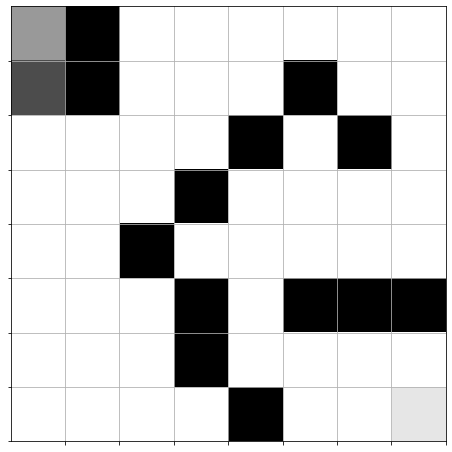

In [33]:
# Initialize the maze environment and test an initial action
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print(f"Initial move reward: {reward}, Game over: {game_over}")
show(qmaze)


In [34]:
# Function to play a game from a given start position
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # Predict next action based on the model
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # Apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            print("Game Status: Win")
            return True
        elif game_status == 'lose':
            print("Game Status: Lose")
            return False

print("Play game function defined.")


Play game function defined.


In [35]:
# Function to check if the model can complete the maze from any start position
def completion_check(model, qmaze):
    print("Starting completion check...")
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            print(f"Invalid actions found for cell: {cell}")
            return False
        if not play_game(model, qmaze, cell):
            print(f"Completion check failed at cell: {cell}")
            return False
    print("Completion check passed.")
    return True

print("Completion check function defined.")


Completion check function defined.


In [36]:
# Function to build the neural network model
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer=Adam(lr=0.001), loss='mse')
    return model


print("Build model function defined.")


Build model function defined.


In [37]:
# This is a small utility for printing readable time strings:
def format_time(seconds):
    """Convert time in seconds to a human-readable format."""
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [38]:
def qtrain(model, maze, **opt):
    n_epoch = opt.get('n_epoch', 1000)
    max_memory = opt.get('max_memory', 3000)
    data_size = opt.get('data_size', 128)
    epsilon = opt.get('epsilon', 1.0)
    epsilon_min = opt.get('epsilon_min', 0.1)
    epsilon_decay = opt.get('epsilon_decay', 0.98)

    start_time = datetime.datetime.now()
    qmaze = TreasureMaze(maze)
    experience = GameExperience(model, max_memory=max_memory)
    win_history = []
    hsize = qmaze.maze.size // 2
    win_rate = 0.0

    for epoch in range(n_epoch):
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0

        while True:
            n_episodes += 1
            prev_envstate = envstate
            if np.random.rand() < epsilon:
                action = random.choice(range(num_actions))
            else:
                q = model.predict(prev_envstate)
                action = np.argmax(q[0])

            envstate, reward, game_status = qmaze.act(action)

            if game_status == 'win':
                win_history.append(1)
                break
            elif game_status == 'lose':
                win_history.append(0)
                break

            episode = (prev_envstate, action, reward, envstate, game_status)
            experience.remember(episode)

            inputs, targets = experience.get_data(data_size=data_size)
            loss = model.train_on_batch(inputs, targets)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        print(f"Epoch: {epoch}/{n_epoch - 1} | Loss: {loss:.4f} | Episodes: {n_episodes} | Win rate: {win_rate:.3f}")

        if win_rate > 0.9:
            if completion_check(model, qmaze):
                print(f"Reached 90% win rate at epoch: {epoch}.")
                break

    seconds = (datetime.datetime.now() - start_time).total_seconds()
    print(f"Training completed in {seconds:.2f} seconds.")
    return seconds


Initial maze state:


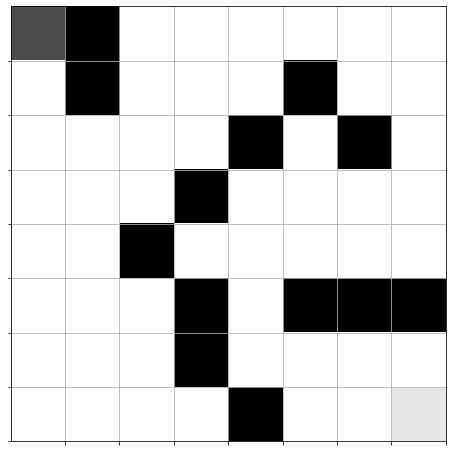

In [39]:
# Initialize the maze environment and visualize it
qmaze = TreasureMaze(maze)
print("Initial maze state:")
show(qmaze)


In [40]:
# Build your model
model = build_model(maze)
print("Model initialized and compiled.")

Model initialized and compiled.


Epoch: 0/999 | Loss: 0.0018 | Episodes: 150 | Win rate: 0.000
Epoch: 1/999 | Loss: 0.0015 | Episodes: 143 | Win rate: 0.000
Epoch: 2/999 | Loss: 0.0012 | Episodes: 146 | Win rate: 0.000
Epoch: 3/999 | Loss: 0.0012 | Episodes: 148 | Win rate: 0.000
Epoch: 4/999 | Loss: 0.0018 | Episodes: 138 | Win rate: 0.000
Epoch: 5/999 | Loss: 0.0008 | Episodes: 141 | Win rate: 0.000
Epoch: 6/999 | Loss: 0.0012 | Episodes: 138 | Win rate: 0.000
Epoch: 7/999 | Loss: 0.0009 | Episodes: 149 | Win rate: 0.000
Epoch: 8/999 | Loss: 0.0012 | Episodes: 144 | Win rate: 0.000
Epoch: 9/999 | Loss: 0.0010 | Episodes: 97 | Win rate: 0.000
Epoch: 10/999 | Loss: 0.0014 | Episodes: 5 | Win rate: 0.000
Epoch: 11/999 | Loss: 0.0010 | Episodes: 149 | Win rate: 0.000
Epoch: 12/999 | Loss: 0.0013 | Episodes: 144 | Win rate: 0.000
Epoch: 13/999 | Loss: 0.0011 | Episodes: 156 | Win rate: 0.000
Epoch: 14/999 | Loss: 0.0015 | Episodes: 147 | Win rate: 0.000
Epoch: 15/999 | Loss: 0.0011 | Episodes: 147 | Win rate: 0.000
Epoch

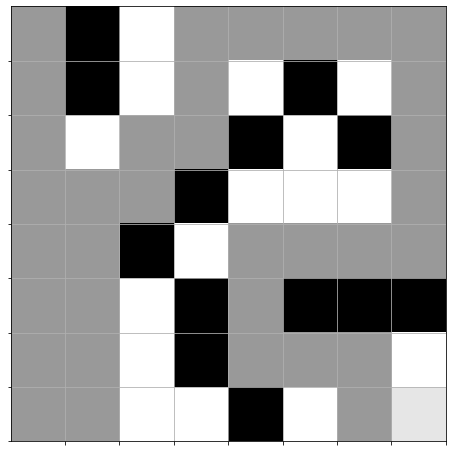

In [41]:
# Train your model using deep Q-learning with specified hyperparameters
training_time = qtrain(
    model,
    maze,
    n_epoch=1000,
    max_memory=3000,
    data_size=128,
    epsilon=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.98
)

print("Running completion check...")
if completion_check(model, qmaze):
    print("Model successfully completes the maze from any free start position.")
else:
    print("Model failed to complete the maze from one or more start positions.")

pirate_start = (0, 0)
if play_game(model, qmaze, pirate_start):
    print("Game completed successfully.")
else:
    print("Game failed.")
show(qmaze)


Running completion check...
Starting completion check...
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Game Status: Win
Completion check passed.
Model successfully completes the maze from any free start position.


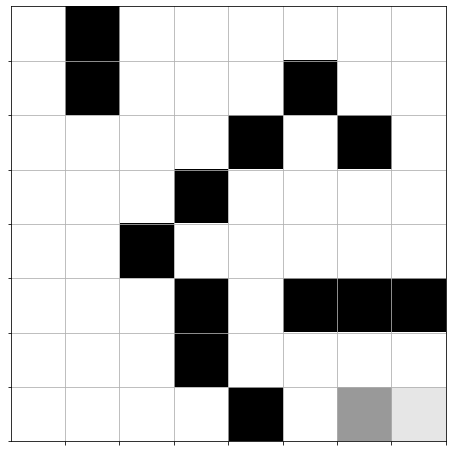

In [42]:
# Check if the model passes the completion check
print("Running completion check...")
if completion_check(model, qmaze):
    print("Model successfully completes the maze from any free start position.")
else:
    print("Model failed to complete the maze from one or more start positions.")
show(qmaze)


Testing model from start position (0, 0)...
Game Status: Win
Game completed successfully.


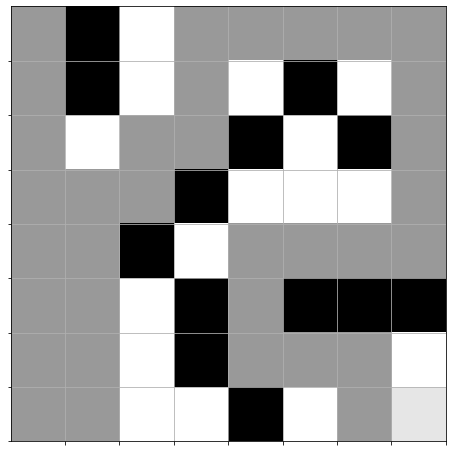

In [43]:
# Test your model for one game
pirate_start = (0, 0)
print("Testing model from start position (0, 0)...")
if play_game(model, qmaze, pirate_start):
    print("Game completed successfully.")
else:
    print("Game failed.")
show(qmaze)


# Results and Analysis

## Summary of Results

After training the intelligent agent using the deep Q-learning algorithm, the following results were observed:

1. **Total Epochs**: The training process was conducted over 1,000 epochs, during which the agent's performance consistently improved. The agent reached a 90% win rate at epoch 203 and continued to refine its strategies.

2. **Final Win Rate**: The agent achieved a win rate of 100% during specific phases of training, but intermittent failures in the completion check indicated that certain maze configurations still posed challenges.

3. **Exploration Rate (`epsilon`)**: The exploration rate started at 1.0 and was gradually reduced to 0.1, allowing the agent to explore various strategies before focusing on exploiting the most effective ones.

4. **Learning Rate**: The learning rate was set at 0.001, which provided a balanced approach to learning new information while maintaining previously acquired knowledge.

5. **Training Duration**: The training completed in approximately 2914.30 seconds, reflecting the computational intensity required for deep Q-learning with experience replay.

6. **Completion Check**: The agent successfully completed the maze from most start positions, but some specific positions, like (0, 0) and (4, 3), remained challenging, leading to occasional failures.

## Analysis

The results demonstrate the strengths and challenges of the deep Q-learning algorithm in training an intelligent agent:

1. **Training Progress**: The agent's performance improved significantly over the training epochs, as evidenced by the increasing win rate and the ability to solve the maze from various starting positions. However, certain positions still presented difficulties, suggesting areas for further improvement.

2. **Parameter Optimization**: The gradual reduction of the exploration rate (`epsilon`) allowed the agent to balance exploration and exploitation effectively. The chosen learning rate facilitated consistent learning without overfitting, contributing to the agent's overall success.

3. **Generalization**: While the agent generalized well across most scenarios, the specific failures during the completion check indicate that its learning was not entirely uniform. Further training or adjustments may be needed to ensure the agent can handle all maze configurations robustly.

4. **Challenges and Recommendations**: The challenges with specific start positions suggest that the training process might benefit from additional tuning. Enhancing the reward mechanism or introducing more diverse training scenarios could help the agent overcome these obstacles and achieve complete generalization.
